# Entity Recognition with LLMs

Fine-tune an LLM to perform batch inference and online serving for entity recognition. 

**Note**: the intent of this tutorial is to show how Ray can be use to implement end-to-end LLM workflows that can extend to any use case. Also the objective of fine-tuning here is not to create the most performant model (increase `num_train_epochs` if you want to though) but to show it can be leveraged for downstream workloads (batch inference and online serving) at scale.

## Data

In [ ]:
import json
import requests
import textwrap
from IPython.display import Code, Image, display

We'll start by downloading our data from cloud storage to local shared storage. 

In [ ]:
%%bash
rm -rf /mnt/cluster_storage/viggo  # clean up
aws s3 cp  s3://viggo-ds/train.jsonl /mnt/cluster_storage/viggo/
aws s3 cp  s3://viggo-ds/val.jsonl /mnt/cluster_storage/viggo/
aws s3 cp  s3://viggo-ds/test.jsonl /mnt/cluster_storage/viggo/
aws s3 cp  s3://viggo-ds/dataset_info.json /mnt/cluster_storage/viggo/

download: s3://viggo-ds/train.jsonl to ../../../mnt/cluster_storage/viggo/train.jsonl
download: s3://viggo-ds/val.jsonl to ../../../mnt/cluster_storage/viggo/val.jsonl
download: s3://viggo-ds/test.jsonl to ../../../mnt/cluster_storage/viggo/test.jsonl
download: s3://viggo-ds/dataset_info.json to ../../../mnt/cluster_storage/viggo/dataset_info.json


In [ ]:
%%bash
head -n 1 /mnt/cluster_storage/viggo/train.jsonl | jq

{
  "instruction": "Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values. This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute']. The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']",
  "input": "Blizzard North is mostly an okay developer, but they released Diablo II for the Mac and so that pushes the game from okay to good in my view.",
  "output": "give_opinion(name[Diablo II], developer[Blizzard North], rating[good], has_mac_release[yes])"
}


In [ ]:
with open("/mnt/cluster_storage/viggo/train.jsonl", "r") as fp:
    first_line = fp.readline()
    item = json.loads(first_line)
system_content = item["instruction"]
print(textwrap.fill(system_content, width=80))

Given a target sentence construct the underlying meaning representation of the
input sentence as a single function with attributes and attribute values. This
function should describe the target string accurately and the function must be
one of the following ['inform', 'request', 'give_opinion', 'confirm',
'verify_attribute', 'suggest', 'request_explanation', 'recommend',
'request_attribute']. The attributes must be one of the following: ['name',
'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres',
'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam',
'has_linux_release', 'has_mac_release', 'specifier']


We also have an info file that identifies the datasets and format --- alpaca and sharegpt (great for multimodal tasks) formats are supported --- to use for post training.

In [ ]:
display(Code(filename="/mnt/cluster_storage/viggo/dataset_info.json", language="json"))

{
    "viggo-train": {
        "file_name": "/mnt/cluster_storage/viggo/train.jsonl",
        "formatting": "alpaca",
        "columns": {
            "prompt": "instruction",
            "query": "input",
            "response": "output"
        }
    },
    "viggo-val": {
        "file_name": "/mnt/cluster_storage/viggo/val.jsonl",
        "formatting": "alpaca",
        "columns": {
            "prompt": "instruction",
            "query": "input",
            "response": "output"
        }
    }
}

## Distributed fine-tuning

We'll use [Ray Train](https://docs.ray.io/en/latest/train/train.html) + [LLaMA-Factory](https://github.com/hiyouga/LLaMA-Factory) to peform multinode training. The parameters for our training workload -- post-training method, dataset location, train/val details, etc. --- can be found in the `llama3_lora_sft_ray.yaml` config file. Check out recipes for even more post-training methods (sft, pretraining, ppo, dpo, kto, etc.) [here](https://github.com/hiyouga/LLaMA-Factory/tree/main/examples).

**Note**: We also support using other tools like [axolotl](https://axolotl-ai-cloud.github.io/axolotl/docs/ray-integration.html) or even [Ray Train + HF Accelreate + FSDP/Deepspeed](https://docs.ray.io/en/latest/train/huggingface-accelerate.html) directly for complete control of your post-training workloads.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/distributed_training.png" width=800>

In [ ]:
import os
from pathlib import Path

In [ ]:
display(Code(filename="llama3_lora_sft_ray.yaml", language="yaml"))

### model
model_name_or_path: meta-llama/Meta-Llama-3-8B-Instruct
trust_remote_code: true

### method
stage: sft
do_train: true
finetuning_type: lora
lora_rank: 8
lora_target: all

### dataset
dataset: viggo-train
dataset_dir: /mnt/cluster_storage/viggo  # shared storage workers have access to
template: llama3
cutoff_len: 2048
max_samples: 1000
overwrite_cache: true
preprocessing_num_workers: 16
dataloader_num_workers: 4

### output
output_dir: /mnt/cluster_storage/viggo/outputs  # should be somewhere workers have access to (ex. s3, nfs)
logging_steps: 10
save_steps: 500
plot_loss: true
overwrite_output_dir: true
save_only_model: false

### ray
ray_run_name: llama3_8b_sft_lora
ray_storage_path: /mnt/cluster_storage/viggo/saves  # should be somewhere workers have access to (ex. s3, nfs)
ray_num_workers: 4  # number of GPUs to use
resources_per_worker:
  GPU: 1
placement_strategy: PACK

### train
per_device_train_batch_size: 1
gradient_accumulation_steps: 8
learning_rate: 1.0e-4
num_train_epochs: 5.0
lr_scheduler_type: cosine
warmup_ratio: 0.1
bf16: true
ddp_timeout: 180000000
resume_from_checkpoint: null

### eval
eval_dataset: viggo-val  # uses same dataset_dir as training data
# val_size: 0.1  # only if using part of training data for validation
per_device_eval_batch_size: 1
eval_strategy: steps
eval_steps: 500

In [ ]:
%%bash
# Run multinode distributed fine-tuning workload
USE_RAY=1 llamafactory-cli train llama3_lora_sft_ray.yaml

INFO 04-06 15:06:44 __init__.py:194] No platform detected, vLLM is running on UnspecifiedPlatform


2025-04-06 15:06:47,584	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 10.0.47.147:6379...
2025-04-06 15:06:47,594	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at https://session-zt5t77xa58pyp3uy28glg2g24d.i.anyscaleuserdata.com 
2025-04-06 15:06:47,596	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_26bd71cec9f23efe437dd6a3ea41321d6be9496e.zip' (0.17MiB) to Ray cluster...
2025-04-06 15:06:47,597	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_26bd71cec9f23efe437dd6a3ea41321d6be9496e.zip'.



View detailed results here: /mnt/cluster_storage/viggo/saves/llama3_8b_sft_lora
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-04-06_14-58-14_355114_2341/artifacts/2025-04-06_15-06-49/llama3_8b_sft_lora/driver_artifacts`
(autoscaler +13s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +13s) [autoscaler] [4xA10G:48CPU-192GB] Attempting to add 1 node(s) to the cluster (increasing from 0 to 1).
(autoscaler +13s) [autoscaler] [4xA10G:48CPU-192GB] Launched 1 instances.

Training started with configuration:
╭───────────────────────────────────────────────────────────────────────────╮
│ Training config                                                           │
├───────────────────────────────────────────────────────────────────────────┤
│ train_loop_config/args/bf16                                          True │
│ train_loop_config/args/cutoff_len                        

(RayTrainWorker pid=3451, ip=10.0.144.159) Setting up process group for: env:// [rank=0, world_size=4]
(TorchTrainer pid=3322, ip=10.0.144.159) Started distributed worker processes: 
(TorchTrainer pid=3322, ip=10.0.144.159) - (node_id=439685917749802c5a7b3150eafecacbf785728db0e7e53bcedd6cb0, ip=10.0.144.159, pid=3451) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=3322, ip=10.0.144.159) - (node_id=439685917749802c5a7b3150eafecacbf785728db0e7e53bcedd6cb0, ip=10.0.144.159, pid=3450) world_rank=1, local_rank=1, node_rank=0
(TorchTrainer pid=3322, ip=10.0.144.159) - (node_id=439685917749802c5a7b3150eafecacbf785728db0e7e53bcedd6cb0, ip=10.0.144.159, pid=3449) world_rank=2, local_rank=2, node_rank=0
(TorchTrainer pid=3322, ip=10.0.144.159) - (node_id=439685917749802c5a7b3150eafecacbf785728db0e7e53bcedd6cb0, ip=10.0.144.159, pid=3448) world_rank=3, local_rank=3, node_rank=0


(RayTrainWorker pid=3451, ip=10.0.144.159) [WARNING|2025-04-06 15:07:59] llamafactory.hparams.parser:148 >> `ddp_find_unused_parameters` needs to be set as False for LoRA in DDP training.
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|2025-04-06 15:07:59] llamafactory.hparams.parser:383 >> Process rank: 0, world size: 4, device: cuda:0, distributed training: True, compute dtype: torch.bfloat16


(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|tokenization_utils_base.py:2060] 2025-04-06 15:08:00,502 >> loading file tokenizer.json from cache at /home/ray/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3-8B-Instruct/snapshots/5f0b02c75b57c5855da9ae460ce51323ea669d8a/tokenizer.json
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|tokenization_utils_base.py:2060] 2025-04-06 15:08:00,502 >> loading file tokenizer.model from cache at None
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|tokenization_utils_base.py:2060] 2025-04-06 15:08:00,502 >> loading file added_tokens.json from cache at None
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|tokenization_utils_base.py:2060] 2025-04-06 15:08:00,502 >> loading file special_tokens_map.json from cache at /home/ray/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3-8B-Instruct/snapshots/5f0b02c75b57c5855da9ae460ce51323ea669d8a/special_tokens_map.json
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|tokenization_utils_base.py:

(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|2025-04-06 15:08:02] llamafactory.data.template:143 >> Add pad token: <|eot_id|>
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|2025-04-06 15:08:02] llamafactory.data.template:143 >> Add <|eot_id|>,<|eom_id|> to stop words.
(RayTrainWorker pid=3451, ip=10.0.144.159) [WARNING|2025-04-06 15:08:02] llamafactory.data.template:148 >> New tokens have been added, make sure `resize_vocab` is True.
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|2025-04-06 15:08:02] llamafactory.data.loader:143 >> Loading dataset /mnt/cluster_storage/viggo/train.jsonl...


(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|tokenization_utils_base.py:2323] 2025-04-06 15:08:02,209 >> Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
(RayTrainWorker pid=3451, ip=10.0.144.159) Setting num_proc from 16 back to 1 for the train split to disable multiprocessing as it only contains one shard.
Generating train split: 0 examples [00:00, ? examples/s]
Generating train split: 10206 examples [00:00, 99768.72 examples/s] 
Converting format of dataset (num_proc=16): 100%|██████████| 1000/1000 [00:00<00:00, 5273.40 examples/s]


(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|2025-04-06 15:08:03] llamafactory.data.loader:143 >> Loading dataset /mnt/cluster_storage/viggo/val.jsonl...


(RayTrainWorker pid=3451, ip=10.0.144.159) Setting num_proc from 16 back to 1 for the train split to disable multiprocessing as it only contains one shard.
Generating train split: 714 examples [00:00, 99655.02 examples/s]
Running tokenizer on dataset (num_proc=16):  69%|██████▉   | 690/1000 [00:02<00:00, 454.66 examples/s]
(RayTrainWorker pid=3451, ip=10.0.144.159) [rank0]:[W406 15:08:03.082780279 ProcessGroupNCCL.cpp:4115] [PG ID 0 PG GUID 0 Rank 0]  using GPU 0 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.Specify device_ids in barrier() to force use of a particular device,or call init_process_group() with a device_id. [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
Running tokenizer on datas

(RayTrainWorker pid=3451, ip=10.0.144.159) training example:
(RayTrainWorker pid=3451, ip=10.0.144.159) input_ids:
(RayTrainWorker pid=3451, ip=10.0.144.159) [128000, 128006, 882, 128007, 271, 22818, 264, 2218, 11914, 9429, 279, 16940, 7438, 13340, 315, 279, 1988, 11914, 439, 264, 3254, 734, 449, 8365, 323, 7180, 2819, 13, 1115, 734, 1288, 7664, 279, 2218, 925, 30357, 323, 279, 734, 2011, 387, 832, 315, 279, 2768, 2570, 41540, 518, 364, 2079, 518, 364, 47530, 10499, 37400, 518, 364, 14119, 518, 364, 12728, 17209, 518, 364, 96861, 518, 364, 2079, 2769, 36990, 518, 364, 67689, 518, 364, 2079, 17209, 7352, 578, 8365, 2011, 387, 832, 315, 279, 2768, 25, 2570, 609, 518, 364, 4683, 25596, 4257, 518, 364, 23859, 14987, 518, 364, 35501, 518, 364, 288, 10910, 518, 364, 22696, 518, 364, 65011, 518, 364, 3517, 623, 86191, 518, 364, 4752, 26190, 3517, 518, 364, 16111, 82, 518, 364, 10547, 4570, 1284, 14922, 518, 364, 4752, 78563, 25596, 518, 364, 4752, 23647, 25596, 518, 364, 68351, 4532, 5028, 39

Running tokenizer on dataset (num_proc=16): 100%|██████████| 714/714 [00:03<00:00, 236.86 examples/s]


(RayTrainWorker pid=3451, ip=10.0.144.159) eval example:
(RayTrainWorker pid=3451, ip=10.0.144.159) input_ids:
(RayTrainWorker pid=3451, ip=10.0.144.159) [128000, 128006, 882, 128007, 271, 22818, 264, 2218, 11914, 9429, 279, 16940, 7438, 13340, 315, 279, 1988, 11914, 439, 264, 3254, 734, 449, 8365, 323, 7180, 2819, 13, 1115, 734, 1288, 7664, 279, 2218, 925, 30357, 323, 279, 734, 2011, 387, 832, 315, 279, 2768, 2570, 41540, 518, 364, 2079, 518, 364, 47530, 10499, 37400, 518, 364, 14119, 518, 364, 12728, 17209, 518, 364, 96861, 518, 364, 2079, 2769, 36990, 518, 364, 67689, 518, 364, 2079, 17209, 7352, 578, 8365, 2011, 387, 832, 315, 279, 2768, 25, 2570, 609, 518, 364, 4683, 25596, 4257, 518, 364, 23859, 14987, 518, 364, 35501, 518, 364, 288, 10910, 518, 364, 22696, 518, 364, 65011, 518, 364, 3517, 623, 86191, 518, 364, 4752, 26190, 3517, 518, 364, 16111, 82, 518, 364, 10547, 4570, 1284, 14922, 518, 364, 4752, 78563, 25596, 518, 364, 4752, 23647, 25596, 518, 364, 68351, 4532, 30128, 19085

(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|configuration_utils.py:699] 2025-04-06 15:08:11,967 >> loading configuration file config.json from cache at /home/ray/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3-8B-Instruct/snapshots/5f0b02c75b57c5855da9ae460ce51323ea669d8a/config.json
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|configuration_utils.py:771] 2025-04-06 15:08:11,968 >> Model config LlamaConfig {
(RayTrainWorker pid=3451, ip=10.0.144.159)   "architectures": [
(RayTrainWorker pid=3451, ip=10.0.144.159)     "LlamaForCausalLM"
(RayTrainWorker pid=3451, ip=10.0.144.159)   ],
(RayTrainWorker pid=3451, ip=10.0.144.159)   "attention_bias": false,
(RayTrainWorker pid=3451, ip=10.0.144.159)   "attention_dropout": 0.0,
(RayTrainWorker pid=3451, ip=10.0.144.159)   "bos_token_id": 128000,
(RayTrainWorker pid=3451, ip=10.0.144.159)   "eos_token_id": 128009,
(RayTrainWorker pid=3451, ip=10.0.144.159)   "head_dim": 128,
(RayTrainWorker pid=3451, ip=10.0.144.159)   "hidden

(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|2025-04-06 15:08:34] llamafactory.model.model_utils.checkpointing:143 >> Gradient checkpointing enabled.
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|2025-04-06 15:08:34] llamafactory.model.model_utils.attention:143 >> Using torch SDPA for faster training and inference.
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|2025-04-06 15:08:34] llamafactory.model.adapter:143 >> Upcasting trainable params to float32.
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|2025-04-06 15:08:34] llamafactory.model.adapter:143 >> Fine-tuning method: LoRA
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|2025-04-06 15:08:34] llamafactory.model.model_utils.misc:143 >> Found linear modules: down_proj,o_proj,up_proj,v_proj,q_proj,gate_proj,k_proj


(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|configuration_utils.py:1094] 2025-04-06 15:08:34,822 >> loading configuration file generation_config.json from cache at /home/ray/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3-8B-Instruct/snapshots/5f0b02c75b57c5855da9ae460ce51323ea669d8a/generation_config.json
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|configuration_utils.py:1139] 2025-04-06 15:08:34,822 >> Generate config GenerationConfig {
(RayTrainWorker pid=3451, ip=10.0.144.159)   "bos_token_id": 128000,
(RayTrainWorker pid=3451, ip=10.0.144.159)   "do_sample": true,
(RayTrainWorker pid=3451, ip=10.0.144.159)   "eos_token_id": [
(RayTrainWorker pid=3451, ip=10.0.144.159)     128001,
(RayTrainWorker pid=3451, ip=10.0.144.159)     128009
(RayTrainWorker pid=3451, ip=10.0.144.159)   ],
(RayTrainWorker pid=3451, ip=10.0.144.159)   "max_length": 4096,
(RayTrainWorker pid=3451, ip=10.0.144.159)   "temperature": 0.6,
(RayTrainWorker pid=3451, ip=10.0.144.159)   "top_p": 0.

(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|2025-04-06 15:08:35] llamafactory.model.loader:143 >> trainable params: 20,971,520 || all params: 8,051,232,768 || trainable%: 0.2605


(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|trainer.py:748] 2025-04-06 15:08:35,240 >> Using auto half precision backend
(RayTrainWorker pid=3451, ip=10.0.144.159) [WARNING|trainer.py:783] 2025-04-06 15:08:35,241 >> No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
(RayTrainWorker pid=3448, ip=10.0.144.159) No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|trainer.py:2409] 2025-04-06 15:08:41,752 >> ***** Running training *****
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|trainer.py:2410] 2025-04-06 15:08:41,752 >>   Num

(RayTrainWorker pid=3451, ip=10.0.144.159) {'loss': 1.9137, 'grad_norm': 3.7507615089416504, 'learning_rate': 6.25e-05, 'epoch': 0.32}


 13%|█▎        | 20/155 [00:56<06:24,  2.85s/it] 


(RayTrainWorker pid=3451, ip=10.0.144.159) {'loss': 0.5527, 'grad_norm': 1.3114871978759766, 'learning_rate': 9.979581007037776e-05, 'epoch': 0.64}


 19%|█▊        | 29/155 [01:22<05:43,  2.72s/it] 


(RayTrainWorker pid=3451, ip=10.0.144.159) {'loss': 0.1674, 'grad_norm': 0.7684409022331238, 'learning_rate': 9.751778332739033e-05, 'epoch': 0.96}


 25%|██▌       | 39/155 [01:48<05:14,  2.71s/it] 


(RayTrainWorker pid=3451, ip=10.0.144.159) {'loss': 0.0672, 'grad_norm': 0.6747345328330994, 'learning_rate': 9.282275574435281e-05, 'epoch': 1.26}


 32%|███▏      | 49/155 [02:16<04:56,  2.79s/it] 


(RayTrainWorker pid=3451, ip=10.0.144.159) {'loss': 0.0435, 'grad_norm': 0.8540425896644592, 'learning_rate': 8.594954076788736e-05, 'epoch': 1.58}


 38%|███▊      | 59/155 [02:44<04:31,  2.83s/it] 


(RayTrainWorker pid=3451, ip=10.0.144.159) {'loss': 0.0286, 'grad_norm': 0.6202750205993652, 'learning_rate': 7.724774574936188e-05, 'epoch': 1.9}


 45%|████▍     | 69/155 [03:10<03:58,  2.77s/it] 


(RayTrainWorker pid=3451, ip=10.0.144.159) {'loss': 0.0143, 'grad_norm': 0.5829706788063049, 'learning_rate': 6.715998910228296e-05, 'epoch': 2.19}


 51%|█████     | 79/155 [03:38<03:28,  2.74s/it] 


(RayTrainWorker pid=3451, ip=10.0.144.159) {'loss': 0.0094, 'grad_norm': 0.6517273187637329, 'learning_rate': 5.619938643480561e-05, 'epoch': 2.51}


 58%|█████▊    | 90/155 [04:09<03:05,  2.86s/it] 


(RayTrainWorker pid=3451, ip=10.0.144.159) {'loss': 0.0137, 'grad_norm': 0.3563719689846039, 'learning_rate': 4.4923450829394605e-05, 'epoch': 2.83}


 64%|██████▍   | 99/155 [04:33<02:29,  2.67s/it] 


(RayTrainWorker pid=3451, ip=10.0.144.159) {'loss': 0.0054, 'grad_norm': 0.2933689057826996, 'learning_rate': 3.390573483674142e-05, 'epoch': 3.13}


 70%|███████   | 109/155 [05:01<02:09,  2.81s/it]0m 


(RayTrainWorker pid=3451, ip=10.0.144.159) {'loss': 0.0043, 'grad_norm': 0.2936941087245941, 'learning_rate': 2.3706656619162278e-05, 'epoch': 3.45}


 77%|███████▋  | 119/155 [05:28<01:39,  2.76s/it]0m 


(RayTrainWorker pid=3451, ip=10.0.144.159) {'loss': 0.0047, 'grad_norm': 0.19297488033771515, 'learning_rate': 1.484499417709087e-05, 'epoch': 3.77}


 83%|████████▎ | 129/155 [05:55<01:04,  2.48s/it]0m 


(RayTrainWorker pid=3451, ip=10.0.144.159) {'loss': 0.0049, 'grad_norm': 0.05336451530456543, 'learning_rate': 7.77149761010898e-06, 'epoch': 4.06}


 90%|████████▉ | 139/155 [06:23<00:45,  2.85s/it]0m 


(RayTrainWorker pid=3451, ip=10.0.144.159) {'loss': 0.0014, 'grad_norm': 0.08628690987825394, 'learning_rate': 2.8459616297395466e-06, 'epoch': 4.38}


 96%|█████████▌| 149/155 [06:51<00:17,  2.84s/it]0m 


(RayTrainWorker pid=3451, ip=10.0.144.159) {'loss': 0.0026, 'grad_norm': 0.15772362053394318, 'learning_rate': 3.1892453488058803e-07, 'epoch': 4.7}


100%|██████████| 155/155 [07:08<00:00,  2.81s/it][INFO|trainer.py:3966] 2025-04-06 15:15:51,023 >> Saving model checkpoint to /mnt/cluster_storage/viggo/outputs/checkpoint-155
(RayTrainWorker pid=3448, ip=10.0.144.159) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/viggo/saves/llama3_8b_sft_lora/TorchTrainer_6ffa1_00000_0_2025-04-06_15-06-49/checkpoint_000000)
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|configuration_utils.py:699] 2025-04-06 15:15:51,327 >> loading configuration file config.json from cache at /home/ray/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3-8B-Instruct/snapshots/5f0b02c75b57c5855da9ae460ce51323ea669d8a/config.json
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|configuration_utils.py:771] 2025-04-06 15:15:51,328 >> Model config LlamaConfig {
(RayTrainWorker pid=3451, ip=10.0.144.159)   "architectures": [
(RayTrainWorker pid=3451, ip=10.0.144.159)     "LlamaForCausalLM"
(RayTrainWorker pid=3451, ip=10.0.


Training finished iteration 1 at 2025-04-06 15:15:54. Total running time: 9min 5s
╭─────────────────────────────────────────╮
│ Training result                         │
├─────────────────────────────────────────┤
│ checkpoint_dir_name   checkpoint_000000 │
│ time_this_iter_s              482.24643 │
│ time_total_s                  482.24643 │
│ training_iteration                    1 │
│ epoch                             4.704 │
│ grad_norm                       0.15772 │
│ learning_rate                        0. │
│ loss                             0.0026 │
│ step                                150 │
╰─────────────────────────────────────────╯
Training saved a checkpoint for iteration 1 at: (local)/mnt/cluster_storage/viggo/saves/llama3_8b_sft_lora/TorchTrainer_6ffa1_00000_0_2025-04-06_15-06-49/checkpoint_000000
(RayTrainWorker pid=3451, ip=10.0.144.159) {'train_runtime': 432.7067, 'train_samples_per_second': 11.555, 'train_steps_per_second': 0.358, 'train_loss': 0.1828844992744346,

(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|trainer.py:2665] 2025-04-06 15:15:54,462 >> 
(RayTrainWorker pid=3451, ip=10.0.144.159) 
(RayTrainWorker pid=3451, ip=10.0.144.159) Training completed. Do not forget to share your model on huggingface.co/models =)
(RayTrainWorker pid=3451, ip=10.0.144.159) 
(RayTrainWorker pid=3451, ip=10.0.144.159) 
100%|██████████| 155/155 [07:12<00:00,  2.79s/it]0m 
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|trainer.py:3966] 2025-04-06 15:15:54,595 >> Saving model checkpoint to /mnt/cluster_storage/viggo/outputs
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|configuration_utils.py:699] 2025-04-06 15:15:54,883 >> loading configuration file config.json from cache at /home/ray/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3-8B-Instruct/snapshots/5f0b02c75b57c5855da9ae460ce51323ea669d8a/config.json
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|configuration_utils.py:771] 2025-04-06 15:15:54,884 >> Model config LlamaConfig {
(RayTrainWor

(RayTrainWorker pid=3451, ip=10.0.144.159) ***** train metrics *****
(RayTrainWorker pid=3451, ip=10.0.144.159)   epoch                    =      4.864
(RayTrainWorker pid=3451, ip=10.0.144.159)   total_flos               = 43426535GF
(RayTrainWorker pid=3451, ip=10.0.144.159)   train_loss               =     0.1829
(RayTrainWorker pid=3451, ip=10.0.144.159)   train_runtime            = 0:07:12.70
(RayTrainWorker pid=3451, ip=10.0.144.159)   train_samples_per_second =     11.555
(RayTrainWorker pid=3451, ip=10.0.144.159)   train_steps_per_second   =      0.358
(RayTrainWorker pid=3451, ip=10.0.144.159) Figure saved at: /mnt/cluster_storage/viggo/outputs/training_loss.png
(RayTrainWorker pid=3451, ip=10.0.144.159) [WARNING|2025-04-06 15:15:55] llamafactory.extras.ploting:148 >> No metric eval_loss to plot.
(RayTrainWorker pid=3451, ip=10.0.144.159) [WARNING|2025-04-06 15:15:55] llamafactory.extras.ploting:148 >> No metric eval_accuracy to plot.


(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|trainer.py:4289] 2025-04-06 15:15:55,709 >> 
(RayTrainWorker pid=3451, ip=10.0.144.159) ***** Running Evaluation *****
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|trainer.py:4291] 2025-04-06 15:15:55,709 >>   Num examples = 714
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|trainer.py:4294] 2025-04-06 15:15:55,710 >>   Batch size = 1
  1%|          | 2/179 [00:00<00:09, 18.33it/s] 
(RayTrainWorker pid=3451, ip=10.0.144.159) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/viggo/saves/llama3_8b_sft_lora/TorchTrainer_6ffa1_00000_0_2025-04-06_15-06-49/checkpoint_000000) [repeated 3x across cluster]
100%|██████████| 179/179 [00:19<00:00,  7.14it/s]0m 


(RayTrainWorker pid=3451, ip=10.0.144.159) ***** eval metrics *****
(RayTrainWorker pid=3451, ip=10.0.144.159)   epoch                             =      4.864
(RayTrainWorker pid=3451, ip=10.0.144.159)   eval_viggo-val_loss               =     0.1168
(RayTrainWorker pid=3451, ip=10.0.144.159)   eval_viggo-val_runtime            = 0:00:19.83
(RayTrainWorker pid=3451, ip=10.0.144.159)   eval_viggo-val_samples_per_second =     36.005
(RayTrainWorker pid=3451, ip=10.0.144.159)   eval_viggo-val_steps_per_second   =      9.026


100%|██████████| 179/179 [00:19<00:00,  9.17it/s]0m 
(RayTrainWorker pid=3451, ip=10.0.144.159) [INFO|modelcard.py:449] 2025-04-06 15:16:15,604 >> Dropping the following result as it does not have all the necessary fields:
(RayTrainWorker pid=3451, ip=10.0.144.159) {'task': {'name': 'Causal Language Modeling', 'type': 'text-generation'}}



Training completed after 1 iterations at 2025-04-06 15:16:17. Total running time: 9min 28s


2025-04-06 15:16:17,517	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/cluster_storage/viggo/saves/llama3_8b_sft_lora' in 0.0217s.


<div class="alert alert-block alert"> <b> 🔎 Monitoring and Debugging with Ray</b> 


OSS Ray offers an extensive [observability suite](https://docs.ray.io/en/latest/ray-observability/index.html) that offers logs and an observability dashboard that we can use to monitor and debug. The dashboard includes a lot of different components such as:

-  memory, utilization, etc. of the tasks running in our [cluster](https://docs.ray.io/en/latest/ray-observability/getting-started.html#dash-node-view)

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/cluster_util.png" width=700>

- views to see all our running tasks, utilization across instance types, autoscaling, etc.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/observability_views.png" width=1000>


<div class="alert alert-block alert"> <b> 🔎➕➕ Monitoring and Debugging on Anyscale</b> 

While OSS Ray comes with an extensive obervability suite, Anyscale takes it many steps further to make it even easier and faster to monitor and debug your workloads.

- [unified log viewer](https://docs.anyscale.com/monitoring/accessing-logs/) to see logs from *all* our driver and worker processes
- Ray workload specific dashboard (Data, Train, etc.) that can breakdown the tasks. For example, our training workload above can be observed live through the Train specific Ray Workloads dashboard:

<img src="images/train_dashboard.png" width=700>




<div class="alert alert-block alert"> <b> 🗂️ Storage on Anyscale</b> 

We can always store to our data inside [any storage buckets](https://docs.anyscale.com/configuration/storage/#private-storage-buckets) but Anyscale offers a [default storage bucket](https://docs.anyscale.com/configuration/storage/#anyscale-default-storage-bucket) to make things even easier. We also have plenty of other [storage options](https://docs.anyscale.com/configuration/storage/) as well (shared at the cluster, user and cloud levels).

In [ ]:
%%bash
# Anyscale default storage bucket
echo $ANYSCALE_ARTIFACT_STORAGE

s3://anyscale-test-data-cld-i2w99rzq8b6lbjkke9y94vi5/org_7c1Kalm9WcX2bNIjW53GUT/cld_kvedZWag2qA8i5BjxUevf5i7/artifact_storage


In [ ]:
%%bash
# Save fine-tuning artifacts to cloud storage
aws s3 rm $ANYSCALE_ARTIFACT_STORAGE/viggo --recursive --quiet
aws s3 cp /mnt/cluster_storage/viggo/outputs $ANYSCALE_ARTIFACT_STORAGE/viggo/outputs --recursive --quiet
aws s3 cp $2 /mnt/cluster_storage/viggo/saves $ANYSCALE_ARTIFACT_STORAGE/viggo/saves --recursive --quiet

In [ ]:
display(Code(filename="/mnt/cluster_storage/viggo/outputs/all_results.json", language="json"))

{
    "epoch": 4.864,
    "eval_viggo-val_loss": 0.11676677316427231,
    "eval_viggo-val_runtime": 19.8306,
    "eval_viggo-val_samples_per_second": 36.005,
    "eval_viggo-val_steps_per_second": 9.026,
    "total_flos": 4.662888690089984e+16,
    "train_loss": 0.1828844992744346,
    "train_runtime": 432.7067,
    "train_samples_per_second": 11.555,
    "train_steps_per_second": 0.358
}

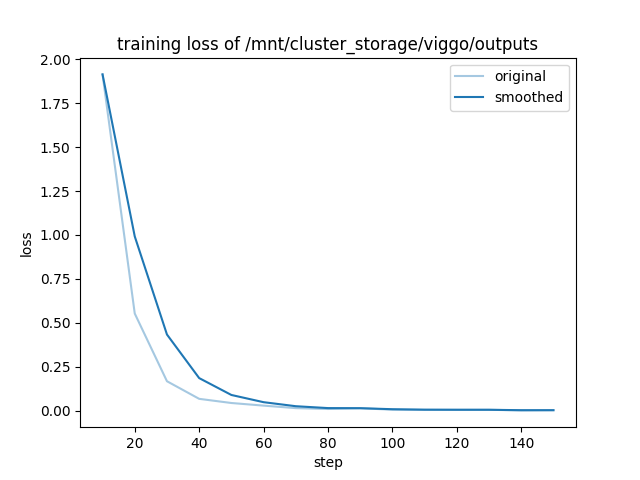

In [ ]:
display(Image(filename="/mnt/cluster_storage/viggo/outputs/training_loss.png"))

In [ ]:
%%bash
ls /mnt/cluster_storage/viggo/saves/llama3_8b_sft_lora

TorchTrainer_6ffa1_00000_0_2025-04-06_15-06-49
basic-variant-state-2025-04-06_15-06-49.json
experiment_state-2025-04-06_15-06-49.json
trainer.pkl
tuner.pkl


In [ ]:
save_dir = Path("/mnt/cluster_storage/viggo/saves/llama3_8b_sft_lora")
trainer_dirs = [d for d in save_dir.iterdir() if d.name.startswith("TorchTrainer_") and d.is_dir()]
latest_trainer = max(trainer_dirs, key=lambda d: d.stat().st_mtime, default=None)
lora_path = f"{latest_trainer}/checkpoint_000000/checkpoint"
s3_lora_path = os.path.join(os.getenv("ANYSCALE_ARTIFACT_STORAGE"), lora_path.split("/mnt/cluster_storage/")[-1])
print (lora_path)
print (s3_lora_path)

/mnt/cluster_storage/viggo/saves/llama3_8b_sft_lora/TorchTrainer_6ffa1_00000_0_2025-04-06_15-06-49/checkpoint_000000/checkpoint
s3://anyscale-test-data-cld-i2w99rzq8b6lbjkke9y94vi5/org_7c1Kalm9WcX2bNIjW53GUT/cld_kvedZWag2qA8i5BjxUevf5i7/artifact_storage/viggo/saves/llama3_8b_sft_lora/TorchTrainer_6ffa1_00000_0_2025-04-06_15-06-49/checkpoint_000000/checkpoint


In [ ]:
%%bash -s "$lora_path"
ls $1

README.md
adapter_config.json
adapter_model.safetensors
optimizer.pt
rng_state_0.pth
rng_state_1.pth
rng_state_2.pth
rng_state_3.pth
scheduler.pt
special_tokens_map.json
tokenizer.json
tokenizer_config.json
trainer_state.json
training_args.bin


## Batch inference 
[`Overview`](https://docs.ray.io/en/latest/data/working-with-llms.html) |  [`API reference`](https://docs.ray.io/en/latest/data/api/llm.html)

The `ray.data.llm` module integrates with key large language model (LLM) inference engines and deployed models to enable LLM batch inference. These llm modules use [Ray Data](https://docs.ray.io/en/latest/data/data.html) under the hood, which makes it extremely easy to distribute our workloads but also ensures that they happen:
- **efficiently**: minimize CPU/GPU idletime with hetergenous resource scheduling.
- **at scale**: streaming execution to petabyte-scale datasets (especially when [working with LLMs](https://docs.ray.io/en/latest/data/working-with-llms.html))
- **reliably** by checkpointing processes, especially when running workloads on spot instanes (with on-demand fallback).
- **flexiblibly**: connect to data from any source, apply your transformations and save to any format/location for your next workload.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/ray_data_solution.png" width=800>

[RayTurbo Data](https://docs.anyscale.com/rayturbo/rayturbo-data) has even more functionality on top of Ray Data:
- **accelerated metadata fetching** to improve reading first time from large datasets 
- **optimized autoscaling** where Jobs can kick off before waiting for the entire cluster to start
- **high reliabilty** where entire fails jobs (head node, cluster, uncaptured exceptions, etc.) can resume from checkpoints (OSS Ray can only recover from worker node failures)

Let's start by defining the [vLLM engine processor config](https://docs.ray.io/en/latest/data/api/doc/ray.data.llm.vLLMEngineProcessorConfig.html#ray.data.llm.vLLMEngineProcessorConfig) where we can select the model we want to use and the [engine behavior](https://docs.vllm.ai/en/stable/serving/engine_args.html). The model can come from [HuggingFace (HF) Hub](https://huggingface.co/models) or a local model path `/path/to/your/model` (GPTQ, GGUF, or LoRA model formats supported).

<img src="images/data_llm.png" width=800>

In [ ]:
import os
import ray
from ray.data.llm import vLLMEngineProcessorConfig, build_llm_processor
import numpy as np

INFO 04-06 15:22:00 __init__.py:194] No platform detected, vLLM is running on UnspecifiedPlatform


In [ ]:
config = vLLMEngineProcessorConfig(
    model_source="meta-llama/Meta-Llama-3-8B-Instruct",
    runtime_env={"env_vars": {"HF_TOKEN": os.environ.get("HF_TOKEN")}},
    engine_kwargs={
        "enable_lora": True,
        "max_lora_rank": 8,
        "max_loras": 1,
        "pipeline_parallel_size": 1, 
        "tensor_parallel_size": 1,
        "enable_prefix_caching": True,
        "enable_chunked_prefill": True,
        "max_num_batched_tokens": 4096,
        # complete list: https://docs.vllm.ai/en/stable/serving/engine_args.html
    },
    concurrency=1,
    batch_size=16,
    accelerator_type="A10G",
)

Next, we'll pass our config to an [llm processor](https://docs.ray.io/en/master/data/api/doc/ray.data.llm.build_llm_processor.html#ray.data.llm.build_llm_processor) where we can define the preprocessing and postprocessing steps around inference. With our base model defined in the processor config, we can define the lora adapter layers as part of the preprocessing step of the llm processor itself.

In [ ]:
processor = build_llm_processor(
    config,
    preprocess=lambda row: dict(
        model=lora_path,  # REMOVE this line if doing inference with just the base model
        messages=[
            {"role": "system", "content": system_content},
            {"role": "user", "content": row["input"]}
        ],
        sampling_params={
            "temperature": 0.3,
            "max_tokens": 250,
            # complete list: https://docs.vllm.ai/en/stable/api/inference_params.html
        },
    ),
    postprocess=lambda row: {
        **row,  # all contents
        "generated_output": row["generated_text"],
        # add additional outputs
    },
)

2025-04-06 15:22:01,282	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 10.0.47.147:6379...
2025-04-06 15:22:01,292	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at https://session-zt5t77xa58pyp3uy28glg2g24d.i.anyscaleuserdata.com 
2025-04-06 15:22:01,296	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_e28850f3e30418125898e8349c048b7ea11faee6.zip' (1.21MiB) to Ray cluster...
2025-04-06 15:22:01,301	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_e28850f3e30418125898e8349c048b7ea11faee6.zip'.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

(pid=10235) INFO 04-06 15:22:07 __init__.py:194] No platform detected, vLLM is running on UnspecifiedPlatform


In [ ]:
# Evaluation on test dataset
ds = ray.data.read_json("/mnt/cluster_storage/viggo/test.jsonl")  # complete list: https://docs.ray.io/en/latest/data/api/input_output.html
ds = processor(ds)
results = ds.take_all()
results[0]

2025-04-06 15:22:08,347	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-04-06_14-58-14_355114_2341/logs/ray-data
2025-04-06 15:22:08,347	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> ActorPoolMapOperator[Map(_preprocess)->MapBatches(ChatTemplateUDF)] -> ActorPoolMapOperator[MapBatches(TokenizeUDF)] -> ActorPoolMapOperator[MapBatches(vLLMEngineStageUDF)] -> ActorPoolMapOperator[MapBatches(DetokenizeUDF)] -> TaskPoolMapOperator[Map(_postprocess)]


Running 0: 0.00 row [00:00, ? row/s]

(autoscaler +16s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +16s) [autoscaler] [4xA10G:48CPU-192GB] Attempting to add 1 node(s) to the cluster (increasing from 0 to 1).
(autoscaler +21s) [autoscaler] [4xA10G:48CPU-192GB] Launched 1 instances.
(_MapWorker pid=3147, ip=10.0.18.165) INFO 04-06 15:23:06 __init__.py:190] Automatically detected platform cuda.
(_MapWorker pid=3297, ip=10.0.18.165) INFO 04-06 15:23:16 __init__.py:190] Automatically detected platform cuda.
(_MapWorker pid=3387, ip=10.0.18.165) INFO 04-06 15:23:22 __init__.py:190] Automatically detected platform cuda.


(_MapWorker pid=3387, ip=10.0.18.165) Max pending requests is set to 141


(_MapWorker pid=3387, ip=10.0.18.165) INFO 04-06 15:23:32 config.py:1556] Chunked prefill is enabled with max_num_batched_tokens=4096.
(_MapWorker pid=3387, ip=10.0.18.165) WARNING 04-06 15:23:32 config.py:2162] LoRA with chunked prefill is still experimental and may be unstable.
(_MapWorker pid=3387, ip=10.0.18.165) INFO 04-06 15:23:32 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Meta-Llama-3-8B-Instruct', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3-8B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observabi

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.47it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.25it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.19it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.52it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.42it/s]
(_MapWorker pid=3387, ip=10.0.18.165) 


(_MapWorker pid=3387, ip=10.0.18.165) INFO 04-06 15:24:03 model_runner.py:1115] Loading model weights took 14.9634 GB
(_MapWorker pid=3387, ip=10.0.18.165) INFO 04-06 15:24:03 punica_selector.py:18] Using PunicaWrapperGPU.
(_MapWorker pid=3387, ip=10.0.18.165) INFO 04-06 15:24:10 worker.py:267] Memory profiling takes 7.27 seconds
(_MapWorker pid=3387, ip=10.0.18.165) INFO 04-06 15:24:10 worker.py:267] the current vLLM instance can use total_gpu_memory (21.99GiB) x gpu_memory_utilization (0.90) = 19.79GiB
(_MapWorker pid=3387, ip=10.0.18.165) INFO 04-06 15:24:10 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.06GiB; PyTorch activation peak memory takes 1.21GiB; the rest of the memory reserved for KV Cache is 3.56GiB.
(_MapWorker pid=3387, ip=10.0.18.165) INFO 04-06 15:24:11 executor_base.py:110] # CUDA blocks: 1824, # CPU blocks: 2048
(_MapWorker pid=3387, ip=10.0.18.165) INFO 04-06 15:24:11 executor_base.py:115] Maximum concurrency for 8192 tokens per request: 3.56

Capturing CUDA graph shapes:   0%|          | 0/35 [00:00<?, ?it/s]


(_MapWorker pid=3387, ip=10.0.18.165) INFO 04-06 15:24:14 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.


Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:19<00:00,  1.77it/s]


(_MapWorker pid=3387, ip=10.0.18.165) INFO 04-06 15:24:33 model_runner.py:1562] Graph capturing finished in 20 secs, took 0.41 GiB
(_MapWorker pid=3387, ip=10.0.18.165) INFO 04-06 15:24:33 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 30.47 seconds
(_MapWorker pid=4510, ip=10.0.18.165) INFO 04-06 15:24:39 __init__.py:190] Automatically detected platform cuda.


- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- Map(_preprocess)->MapBatches(ChatTemplateUDF) 3: 0.00 row [00:00, ? row/s]

- MapBatches(TokenizeUDF) 4: 0.00 row [00:00, ? row/s]

- MapBatches(vLLMEngineStageUDF) 5: 0.00 row [00:00, ? row/s]

- MapBatches(DetokenizeUDF) 6: 0.00 row [00:00, ? row/s]

- Map(_postprocess) 7: 0.00 row [00:00, ? row/s]

(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) INFO 04-06 15:24:48 metrics.py:455] Avg prompt throughput: 281.1 tokens/s, Avg generation throughput: 1.5 tokens/s, Running: 125 reqs, Swapped: 0 reqs, Pending: 16 reqs, GPU KV cache usage: 20.4%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) INFO 04-06 15:24:48 metrics.py:471] Prefix cache hit rate: GPU: 81.47%, CPU: 0.00%
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) INFO 04-06 15:24:53 metrics.py:455] Avg prompt throughput: 4509.6 tokens/s, Avg generation throughput: 302.3 tokens/s, Running: 140 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 27.7%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) INFO 04-06 15:24:53 metrics.py:471] Prefix cache hit rate: GPU: 82.24%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 553737609bc04a53b545eaf9d4919117 with size 16: 10.307345370999997
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 52291568e0c346c4b123ebe0e3530d0a with size 16: 10.30840715299999
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 12a2f8a8687a421fb3844dfe1b6d5db4 with size 16: 10.474550902999994
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 596785fac78245329ae211286a19fade with size 16: 11.551732603000005
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 4e90d9706bd241308a1b41cf10c53f0c with size 16: 11.800730044999995


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) INFO 04-06 15:24:58 metrics.py:455] Avg prompt throughput: 5925.5 tokens/s, Avg generation throughput: 1015.9 tokens/s, Running: 138 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 33.6%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) INFO 04-06 15:24:58 metrics.py:471] Prefix cache hit rate: GPU: 81.69%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch adbd0996026646ab861c33e4b222faf3 with size 16: 13.106287923000025
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 60e51df98f714d3aac779e5a2c47bc3e with size 16: 13.10677405300001
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch b268c9856159475b8495235be6439ff4 with size 16: 13.270294061000016
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch c614bd7b96d346a78e397bea49a325e5 with size 16: 13.560436906000007
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch af410ea03e304120a33df0571e5fef0f with size 16: 14.043222192999991
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 800c5d363d954b1ba28f571529462b12 with size 16: 14.438946963999996
(MapWorker(

(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) INFO 04-06 15:25:03 metrics.py:455] Avg prompt throughput: 6404.2 tokens/s, Avg generation throughput: 925.2 tokens/s, Running: 141 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 31.9%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) INFO 04-06 15:25:03 metrics.py:471] Prefix cache hit rate: GPU: 82.13%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 11b478992f48484ea4c0c4bac31376f3 with size 16: 18.42661037299999
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 470ea94dd5984c8a88689a8111348af0 with size 16: 18.818971277000003
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 11d8a05ad82f45a69eded4165a1eec50 with size 16: 18.819725673000022
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch da2e5f146f9247cbb7df7aa0270c91e7 with size 16: 18.983983173999974
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch f725ddec3f9744c797bc8fa66cf48219 with size 16: 20.087967562000017
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch f90d7e9179e147ba868bc6ba794b864a with size 16: 20.088472422000024
(MapWorker(

(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) INFO 04-06 15:25:08 metrics.py:455] Avg prompt throughput: 6238.3 tokens/s, Avg generation throughput: 1004.1 tokens/s, Running: 139 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 31.5%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) INFO 04-06 15:25:08 metrics.py:471] Prefix cache hit rate: GPU: 82.60%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch ccbd0ebe14214366a507fec429e1de44 with size 16: 23.53848504200002
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 5a76a2613672461b85456993b84d86c3 with size 16: 23.53901242699999
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch ca6f08f7099447a88502dac108114aae with size 16: 23.779834394000005
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 9b7ef24079864eebbc93eab71cd20e78 with size 16: 23.78044970100001
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch d60fca5dd204476c80754cf66bf488d6 with size 16: 23.780559471000004
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch ed27880fc03746479c26953131ca25cb with size 16: 24.170701027000007
(MapWorker(Ma

(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) INFO 04-06 15:25:14 metrics.py:455] Avg prompt throughput: 6675.4 tokens/s, Avg generation throughput: 988.2 tokens/s, Running: 133 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 28.7%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) INFO 04-06 15:25:14 metrics.py:471] Prefix cache hit rate: GPU: 82.78%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 494108422fdb4c1186bd0757a3b23aea with size 16: 28.563080303999982
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch c573d94efae54417aededb36dde94a43 with size 16: 28.70725019599999
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch aa4534fae9ab48b8a08ca8d31dee259e with size 16: 29.16996366699999
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch f832087ca46f432db7898a4c27949bed with size 16: 29.782041362
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 679e1f0dc1374b59bcd55fc978b572fb with size 16: 29.885283079000004
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 68827e0cd49f4105a9d70b0e769ae1ae with size 16: 30.277618915999994
(MapWorker(MapBatc

(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) INFO 04-06 15:25:19 metrics.py:455] Avg prompt throughput: 7026.0 tokens/s, Avg generation throughput: 948.9 tokens/s, Running: 137 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 31.4%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) INFO 04-06 15:25:19 metrics.py:471] Prefix cache hit rate: GPU: 82.77%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 64a855a54da042e985400045ee577661 with size 16: 34.343725799
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 62f83d8867de4fdb94854b02513a9c3a with size 16: 34.41983118499999
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 47382363302049f196ac294ded1cc674 with size 16: 34.79314973300001
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 44e6e17c8b9643c081cf81e71f366d17 with size 16: 34.930388986000025
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch d375b3c667184065892f70ef80add1d5 with size 16: 34.99969145
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3387, ip=10.0.18.165) [vLLM] Elapsed time for batch 5bf0743b8a1a4c858a49a1f03bcd0cdb with size 16: 35.06523592300002
(MapWorker(MapBatches(vLLM

{'batch_uuid': 'af410ea03e304120a33df0571e5fef0f',
 'embeddings': None,
 'generated_text': 'request(specifier[weirdest])',
 'generated_tokens': [2079, 39309, 3125, 58, 906, 404, 5086, 2526, 128009],
 'input': "What do you think is the weirdest game you've ever played?",
 'instruction': "Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values. This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute']. The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']",
 'messages': [{'content': "Given a target sentence con

In [ ]:
# Exact match (strict!)
matches = 0
for item in results:
    if item["output"] == item["generated_output"]:
        matches += 1
matches / float(len(results))

0.7996306555863343

(autoscaler +7m36s) [autoscaler] Downscaling node i-0325269f43c140a67 (node IP: 10.0.18.165) due to node idle termination.


And of course, we can observe the individual steps in our our batch inference workload through the Anyscale Ray Data dashboard:

<img src="images/data_dashboard.png" width=1000>

<div class="alert alert-info">

💡 For more advanced guides on topics like optimized model loading, multi-lora, openai-compatible endpoints, etc. check out [more examples](https://docs.ray.io/en/latest/data/working-with-llms.html) and the [API reference](https://docs.ray.io/en/latest/data/api/llm.html).

</div>

## Online serving
[`Overview`](https://docs.ray.io/en/latest/serve/llm/serving-llms.html) | [`API reference`](https://docs.ray.io/en/latest/serve/api/index.html#llm-api)

`ray.serve.llm` APIs allow users to deploy multiple LLM models together with a familiar Ray Serve API, while providing compatibility with the OpenAI API.

<img src="images/serve_llm.png" width=500>

Ray Serve LLM is designed with the following features:
- Automatic scaling and load balancing
- Unified multi-node multi-model deployment
- OpenAI compatibility
- Multi-LoRA support with shared base models
- Deep integration with inference engines (vLLM to start)
- Composable multi-model LLM pipelines

[RayTurbo Serve](https://docs.anyscale.com/rayturbo/rayturbo-serve) on Anyscale has even more functionality on top of Ray Serve:
- **fast autoscaling and model loading** to get our services up and running even faster ([5x improvements](https://www.anyscale.com/blog/autoscale-large-ai-models-faster) even for LLMs)
- 54% **higher QPS** and up-to 3x **streaming tokens per second** for high traffic serving use-cases
- **replica compaction** into fewer nodes where possible to reduce resource fragmentation and improve hardware utilization
- **zero-downtime** [incremental rollouts](https://docs.anyscale.com/platform/services/update-a-service/#resource-constrained-updates) so your service is never interrupted
- [**different environments**](https://docs.anyscale.com/platform/services/multi-app/#multiple-applications-in-different-containers) for each service in a multi-serve application
- **multi availability-zone** aware scheduling of Ray Serve replicas to provide higher redundancy to availability zone failures


In [ ]:
import os
from openai import OpenAI  # to use openai api format
from ray import serve
from ray.serve.llm import LLMConfig, LLMServer, LLMRouter

Let's define an [LLM config](https://docs.ray.io/en/latest/serve/api/doc/ray.serve.llm.LLMConfig.html#ray.serve.llm.LLMConfig) where we can define where our model comes from, it's [autoscaling behavior](https://docs.ray.io/en/latest/serve/autoscaling-guide.html#serve-autoscaling), what hardware to use and [engine arguments](https://docs.vllm.ai/en/stable/serving/engine_args.html).

In [ ]:
# Define config
model_id = "llama-3-8b-instruct"  # call it whatever you want
model_source = "meta-llama/Meta-Llama-3-8B-Instruct"  # HF model ID, S3 mirror config, or GCS mirror config
llm_config = LLMConfig(
    model_loading_config={
        "model_id": model_id,
        "model_source": model_source
    },
    lora_config={  # REMOVE this if you are only using a base model
        "dynamic_lora_loading_path": s3_lora_path,
        "max_num_adapters_per_replica": 16,  # we only have 1
    },
    runtime_env={"env_vars": {"HF_TOKEN": os.environ.get("HF_TOKEN")}},
    deployment_config={
        "autoscaling_config": {
            "min_replicas": 1, 
            "max_replicas": 2,
            # complete list: https://docs.ray.io/en/latest/serve/autoscaling-guide.html#serve-autoscaling
        }
    },
    accelerator_type="A10G",
    engine_kwargs={
        "tensor_parallel_size": 1,
        # complete list: https://docs.vllm.ai/en/stable/serving/engine_args.html
    },
)

Now we'll deploy our llm config as an application. And since this is all built on top of [Ray Serve](https://docs.ray.io/en/latest/serve/index.html), we can have advanvced service logic around composing models together, deploying multiple applications, model multiplexing, observability, etc.

In [ ]:
# Deploy
deployment = LLMServer.as_deployment(llm_config.get_serve_options(name_prefix="VLLM:")).bind(llm_config)
llm_app = LLMRouter.as_deployment().bind([deployment])
serve.run(llm_app)

(ProxyActor pid=22873) INFO 2025-04-06 14:45:54,295 proxy 10.0.23.207 -- Proxy starting on node 4e6eb0bd757d7fbd341bf47e4259871a0b6dfd27e02443d8088a9cae (HTTP port: 8000).
INFO 2025-04-06 14:45:54,384 serve 14736 -- Started Serve in namespace "serve".
(ProxyActor pid=22873) INFO 2025-04-06 14:45:54,351 proxy 10.0.23.207 -- Got updated endpoints: {}.
(ServeController pid=22811) INFO 2025-04-06 14:45:54,415 controller 22811 -- Deploying new version of Deployment(name='VLLM:llama-3-8b-instruct', app='default') (initial target replicas: 1).
(ServeController pid=22811) INFO 2025-04-06 14:45:54,416 controller 22811 -- Deploying new version of Deployment(name='LLMRouter', app='default') (initial target replicas: 2).
(ProxyActor pid=22873) INFO 2025-04-06 14:45:54,419 proxy 10.0.23.207 -- Got updated endpoints: {Deployment(name='LLMRouter', app='default'): EndpointInfo(route='/', app_is_cross_language=False)}.
(ProxyActor pid=22873) INFO 2025-04-06 14:45:54,437 proxy 10.0.23.207 -- Started <ra

(autoscaler +9m54s) [autoscaler] [4xA10G:48CPU-192GB] Attempting to add 1 node(s) to the cluster (increasing from 0 to 1).
(autoscaler +9m54s) [autoscaler] [4xA10G:48CPU-192GB] Launched 1 instances.


(ServeController pid=22811) WARNING 2025-04-06 14:46:24,592 controller 22811 -- Deployment 'VLLM:llama-3-8b-instruct' in application 'default' has 1 replicas that have taken more than 30s to be scheduled. This may be due to waiting for the cluster to auto-scale or for a runtime environment to be installed. Resources required for each replica: [{"CPU": 1.0}, {"GPU": 1.0, "accelerator_type:A10G": 0.001}], total resources available: {}. Use `ray status` for more details.
(ServeController pid=22811) WARNING 2025-04-06 14:46:24,593 controller 22811 -- Deployment 'LLMRouter' in application 'default' has 2 replicas that have taken more than 30s to be scheduled. This may be due to waiting for the cluster to auto-scale or for a runtime environment to be installed. Resources required for each replica: {"CPU": 1}, total resources available: {}. Use `ray status` for more details.
(ServeController pid=22811) WARNING 2025-04-06 14:46:54,628 controller 22811 -- Deployment 'VLLM:llama-3-8b-instruct' i

(ServeReplica:default:LLMRouter pid=3146, ip=10.0.109.239) INFO 04-06 14:46:55 __init__.py:190] Automatically detected platform cuda.


(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) INFO 2025-04-06 14:46:56,711 default_VLLM:llama-3-8b-instruct pxm9ni61 -- No cloud storage mirror configured
(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) INFO 2025-04-06 14:46:56,711 default_VLLM:llama-3-8b-instruct pxm9ni61 -- Downloading the tokenizer for meta-llama/Meta-Llama-3-8B-Instruct
(ProxyActor pid=3148, ip=10.0.109.239) INFO 2025-04-06 14:46:57,636 proxy 10.0.109.239 -- Proxy starting on node 578d2be5fea1addd112065824ea02cfc6cd374ada91da022e4dc5409 (HTTP port: 8000).
(ProxyActor pid=3148, ip=10.0.109.239) INFO 2025-04-06 14:46:57,732 proxy 10.0.109.239 -- Got updated endpoints: {Deployment(name='LLMRouter', app='default'): EndpointInfo(route='/', app_is_cross_language=False)}.
(ProxyActor pid=3148, ip=10.0.109.239) INFO 2025-04-06 14:46:57,747 proxy 10.0.109.239 -- Started <ray.serve._private.router.SharedRouterLongPollClient object at 0x7227c88a66c0>.
(ServeReplica:default

(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) INFO 04-06 14:47:11 config.py:542] This model supports multiple tasks: {'generate', 'embed', 'score', 'classify', 'reward'}. Defaulting to 'generate'.
(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) INFO 04-06 14:46:55 __init__.py:190] Automatically detected platform cuda. [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) INFO 2025-04-06 14:47:11,744 default_VLLM:llama-3-8b-instruct pxm9ni61 -- [STATUS] Getting the server ready ...


(pid=4023, ip=10.0.109.239) INFO 04-06 14:47:16 __init__.py:190] Automatically detected platform cuda.


(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 2025-04-06 14:47:17,257 serve 4023 -- Clearing the current platform cache ...


(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:47:17 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Meta-Llama-3-8B-Instruct', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3-8B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=meta-llama/Meta-Llama-3-8B-Instruct, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_cachin

(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) Connecting to existing Ray cluster at address: 10.0.23.207:6379...
(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) Calling ray.init() again after it has already been called.


(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:47:18 ray_distributed_executor.py:149] use_ray_spmd_worker: False


(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) INFO 2025-04-06 14:47:21,792 default_VLLM:llama-3-8b-instruct pxm9ni61 -- [STATUS] Waiting for engine process ...


(pid=4117, ip=10.0.109.239) INFO 04-06 14:47:23 __init__.py:190] Automatically detected platform cuda.


(ServeController pid=22811) WARNING 2025-04-06 14:47:24,653 controller 22811 -- Deployment 'VLLM:llama-3-8b-instruct' in application 'default' has 1 replicas that have taken more than 30s to initialize.
(ServeController pid=22811) This may be caused by a slow __init__ or reconfigure method.
(ServeController pid=22811) WARNING 2025-04-06 14:47:24,654 controller 22811 -- Deployment 'LLMRouter' in application 'default' has 2 replicas that have taken more than 30s to initialize.
(ServeController pid=22811) This may be caused by a slow __init__ or reconfigure method.


(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:47:24 cuda.py:230] Using Flash Attention backend.
(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:47:25 model_runner.py:1110] Starting to load model meta-llama/Meta-Llama-3-8B-Instruct...
(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:47:26 weight_utils.py:252] Using model weights format ['*.safetensors']


(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) INFO 2025-04-06 14:47:32,842 default_VLLM:llama-3-8b-instruct pxm9ni61 -- [STATUS] Waiting for engine process ...
(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) INFO 2025-04-06 14:47:43,892 default_VLLM:llama-3-8b-instruct pxm9ni61 -- [STATUS] Waiting for engine process ...
Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.47it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.24it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.19it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.52it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.41it/s]
(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) 


(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:47:48 model_runner.py:1115] Loading model weights took 14.9595 GB
(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:47:50 worker.py:267] Memory profiling takes 2.36 seconds
(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:47:50 worker.py:267] the current vLLM instance can use total_gpu_memory (21.99GiB) x gpu_memory_utilization (0.90) = 19.79GiB
(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:47:50 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.06GiB; PyTorch activation peak memory takes 1.23GiB; the rest of the memory reserved for KV Cache is 3.54GiB.
(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:47:51 executor_base.py:110] # CUDA blocks: 1812, # CPU blocks: 2048
(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:47:51 executor_base.py:115] Maximum concurrency for 8192 tokens per request: 3.54x


Capturing CUDA graph shapes:   0%|          | 0/35 [00:00<?, ?it/s]


(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:47:54 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.


(ServeController pid=22811) WARNING 2025-04-06 14:47:54,704 controller 22811 -- Deployment 'VLLM:llama-3-8b-instruct' in application 'default' has 1 replicas that have taken more than 30s to initialize.
(ServeController pid=22811) This may be caused by a slow __init__ or reconfigure method.
(ServeController pid=22811) WARNING 2025-04-06 14:47:54,705 controller 22811 -- Deployment 'LLMRouter' in application 'default' has 2 replicas that have taken more than 30s to initialize.
(ServeController pid=22811) This may be caused by a slow __init__ or reconfigure method.
Capturing CUDA graph shapes:   3%|▎         | 1/35 [00:00<00:19,  1.70it/s]
(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) INFO 2025-04-06 14:47:54,923 default_VLLM:llama-3-8b-instruct pxm9ni61 -- [STATUS] Waiting for engine process ...
Capturing CUDA graph shapes:  63%|██████▎   | 22/35 [00:11<00:06,  2.03it/s]
(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) INFO 2025-04-06 

(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:48:12 model_runner.py:1562] Graph capturing finished in 18 secs, took 0.26 GiB
(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:48:12 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 23.63 seconds
(raylet) WARNING: 4 PYTHON worker processes have been started on node: 4e6eb0bd757d7fbd341bf47e4259871a0b6dfd27e02443d8088a9cae with address: 10.0.23.207. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
(pid=23638) INFO 04-06 14:48:18 __init__.py:194] No platform detected, vLLM is running on UnspecifiedPlatform


(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) INFO 2025-04-06 14:48:19,750 default_VLLM:llama-3-8b-instruct pxm9ni61 bae18a66-746b-4309-a973-1ee6ba112ac8 -- CALL llm_config OK 294.7ms
(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) INFO 2025-04-06 14:48:19,756 default_VLLM:llama-3-8b-instruct pxm9ni61 d9ddf5ed-6eb0-4732-8402-27f14522523e -- CALL llm_config OK 300.1ms
INFO 2025-04-06 14:48:21,786 serve 14736 -- Application 'default' is ready at http://127.0.0.1:8000/.
INFO 2025-04-06 14:48:21,794 serve 14736 -- Started <ray.serve._private.router.SharedRouterLongPollClient object at 0x7284b02a6930>.


DeploymentHandle(deployment='LLMRouter')

In [ ]:
# Initialize client
client = OpenAI(base_url="http://localhost:8000/v1", api_key="fake-key")
response = client.chat.completions.create(
    model=model_id,
    messages=[{"role": "user", "content": "Tell me a joke."}],
    stream=True
)
for chunk in response:
    if chunk.choices[0].delta.content is not None:
        print(chunk.choices[0].delta.content, end="", flush=True)

(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) INFO 2025-04-06 14:48:21,937 default_VLLM:llama-3-8b-instruct pxm9ni61 4d96b857-3f09-4a88-9f7d-0a7c362aa16d -- Received streaming request 4d96b857-3f09-4a88-9f7d-0a7c362aa16d
(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) INFO 2025-04-06 14:48:21,941 default_VLLM:llama-3-8b-instruct pxm9ni61 4d96b857-3f09-4a88-9f7d-0a7c362aa16d -- Request 4d96b857-3f09-4a88-9f7d-0a7c362aa16d started. Prompt: <|begin_of_text|><|start_header_id|>user<|end_header_id|>
(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) 
(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) Tell me a joke.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) 
(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) 
{"asctime": "2025-04-06 14:48:21,997", "levelname": "INFO", "message": "HTTP

(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:48:21 engine.py:275] Added request 4d96b857-3f09-4a88-9f7d-0a7c362aa16d.
(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:48:21 metrics.py:455] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
Here's one:

Why couldn't the bicycle stand up by itself?

Because it was two-tired!

Hope that made you smile!

(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:48:22 engine.py:293] Aborted request 4d96b857-3f09-4a88-9f7d-0a7c362aa16d.


(ServeReplica:default:LLMRouter pid=3145, ip=10.0.109.239) INFO 2025-04-06 14:48:22,909 default_LLMRouter bgqxqemo 4d96b857-3f09-4a88-9f7d-0a7c362aa16d -- POST /v1/chat/completions 200 979.5ms
(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) INFO 2025-04-06 14:48:22,905 default_VLLM:llama-3-8b-instruct pxm9ni61 4d96b857-3f09-4a88-9f7d-0a7c362aa16d -- Request 4d96b857-3f09-4a88-9f7d-0a7c362aa16d finished (stop). Total time: 0.963570107999999s, Queue time: 0.0028231143951416016s, Generation+async time: 0.9607469936048574s, Input tokens: 16, Generated tokens: 28, tokens/s: 45.797697305203975, generated tokens/s: 29.143989194220712.
(ServeReplica:default:VLLM:llama-3-8b-instruct pid=3147, ip=10.0.109.239) INFO 2025-04-06 14:48:22,907 default_VLLM:llama-3-8b-instruct pxm9ni61 4d96b857-3f09-4a88-9f7d-0a7c362aa16d -- CALL /v1/chat/completions OK 970.3ms


(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:48:32 metrics.py:455] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 2.5 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
(_EngineBackgroundProcess pid=4023, ip=10.0.109.239) INFO 04-06 14:48:43 metrics.py:455] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.


And of course, we can observe our running service (deployments and metrics like QPS, latency, etc.) through the [Ray Dashboard](https://docs.ray.io/en/latest/ray-observability/getting-started.html)'s [Serve view](https://docs.ray.io/en/latest/ray-observability/getting-started.html#dash-serve-view):

<img src="images/serve_dashboard.png" width=1000>

<div class="alert alert-info">

💡 For more advanced guides on topics like structured outputs (ex. json), vision LMs, multi-lora on shared base models, using other inference engines (ex. sglang), etc. fast model loading, etc. check out [more examples](https://docs.ray.io/en/latest/serve/llm/overview.html) and the [API reference](https://docs.ray.io/en/latest/serve/llm/api.html).

</div>

### Production

Seamlessly integrate with your existing CI/CD pipelines by leveraging the Anyscale [CLI](https://docs.anyscale.com/reference/quickstart-cli) or [SDK](https://docs.anyscale.com/reference/quickstart-sdk) to deploy [highly available services](https://docs.anyscale.com/platform/services) and run [reliable batch jobs](https://docs.anyscale.com/platform/jobs). Given we've been developing in an environment that's almost identical to production (multinode cluster), this should drastically speed up our dev → prod velocity.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/cicd.png" width=600>


In [ ]:
%%bash
# clean up
rm -rf /mnt/cluster_storage/viggo  # clean up
aws s3 rm $ANYSCALE_ARTIFACT_STORAGE/viggo --recursive --quiet

(_EngineBackgroundProcess pid=4054, ip=10.0.150.21) INFO 04-05 19:35:53 engine.py:293] Aborted request b96829c1-808c-4aa8-b1d5-304f98361560.


(ServeController pid=73936) INFO 2025-04-05 19:45:56,754 controller 73936 -- Downscaling Deployment(name='LLMRouter', app='default') from 2 to 0 replicas. Current ongoing requests: 0.00, current running replicas: 2.
(ServeController pid=73936) INFO 2025-04-05 19:45:56,755 controller 73936 -- Removing 2 replicas from Deployment(name='LLMRouter', app='default').
(ServeController pid=73936) INFO 2025-04-05 19:45:58,782 controller 73936 -- Replica(id='ur53jp9k', deployment='LLMRouter', app='default') is stopped.
(ServeController pid=73936) INFO 2025-04-05 19:45:58,782 controller 73936 -- Replica(id='df9zz1e9', deployment='LLMRouter', app='default') is stopped.
